In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc

In [ ]:
X_train = pd.read_csv('X_train.csv')

X_test_19 = pd.read_csv('X_test_19.csv')
y_test_19 = pd.read_csv('y_test_19.csv')

X_test_04 = pd.read_csv('X_test_04.csv')
y_test_04 = pd.read_csv('y_test_04.csv')

print("X_train:", X_train.shape)
print("X_test_19:",X_test_19.shape)
print("X_test_04:",X_test_04.shape)

X_train: (1132654, 72)
X_test_19: (932294, 72)
X_test_04: (1288025, 72)


In [9]:
# Definizione dell'input layer
input_dim = 72  # Numero di features per ciascun record
input_layer = tf.keras.Input(shape=(input_dim,))

encoder1 = tf.keras.layers.Dense(input_dim, activation='relu')(input_layer)
encoder2 = tf.keras.layers.Dense(int(input_dim/2), activation='relu')(encoder1)
encoder3 = tf.keras.layers.Dense(int(input_dim/4), activation='relu')(encoder2)

decoder1 = tf.keras.layers.Dense(int(input_dim/4), activation='relu')(encoder3)
decoder2 = tf.keras.layers.Dense(int(input_dim/2), activation='relu')(decoder1)
decoder3 = tf.keras.layers.Dense(input_dim, activation='relu')(decoder2)

output_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder3)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam()

# Compilazione dell'autoencoder
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
# Stampa dell'architettura del modello
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 72)             │         5,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 36)             │         2,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 18)             │           666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 72)             │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 72)             │         5,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,496 (68.34 KB)

 Trainable params: 17,496 (68.34 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello con l'early stopping
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,  # Usa il 20% dei dati di training per la validazione
                callbacks=[early_stop])

Epoch 1/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0318 - val_loss: 0.0108
Epoch 2/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 3/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 4/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 5/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0128 - val_loss: 0.0103
Epoch 6/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 7/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 8/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 9/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 10/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0125 - val_loss: 0.0103
Epoch 11/100
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 12/100
3540/

In [12]:
# Salvataggio del modello
autoencoder.save("autoencoder_doppia_simulazione.keras")


In [ ]:
#19_07
reconstructions_19 = autoencoder.predict(X_test_19)
loss_19 = np.mean(np.square(reconstructions_19 - X_test_19), axis=1)

#04_10
reconstructions_04 = autoencoder.predict(X_test_04)
loss_04 = np.mean(np.square(reconstructions_04 - X_test_04), axis=1)

In [9]:
def curva_precision_recall(y_test, loss):

    precision, recall, thresholds_pr = precision_recall_curve(y_test, loss)
    auc_pr = auc(recall, precision)

    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_pr = thresholds_pr[np.argmax(f1_scores)]

    print("AUC-PR:", auc_pr)
    print("Best Threshold (Precision-Recall):", best_threshold_pr)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve (AUC-PR = %0.2f)' % auc_pr, color='b')
    plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', marker='o', label='Best F1-Score')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    return best_threshold_pr

In [13]:
def curva_roc(y_test,loss):
    fpr, tpr, thresholds_roc = roc_curve(y_test, loss)

    roc_auc = auc(fpr, tpr)

    optimal_threshold_index = np.argmax(tpr - fpr) #tpr-fpr è l'indice di Youden
    best_threshold_roc = thresholds_roc[optimal_threshold_index]

    print("AUC-ROC:", roc_auc)
    print("Best Threshold (ROC):", best_threshold_roc)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC-ROC = %0.2f)' % roc_auc, color='b')
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    return best_threshold_roc

In [11]:
def detect_anomaly(new_data, autoencoder, threshold):
    reconstructions = autoencoder.predict(new_data)
    loss = np.mean(np.square(reconstructions - new_data), axis=1)
    anomalies = loss >= threshold
    return anomalies

In [ ]:
#19_07
threshold_roc_19=curva_roc(y_test_19,loss_19)
predicted_labels_roc_19 = detect_anomaly(X_test_19, autoencoder, threshold_roc_19)

threshold_pr_19 = curva_precision_recall(y_test_19, loss_19)
predicted_labels_pr_19 = detect_anomaly(X_test_19, autoencoder, threshold_pr_19)

#04_10
threshold_roc_04=curva_roc(y_test_04,loss_04)
predicted_labels_roc_04 = detect_anomaly(X_test_04, autoencoder, threshold_roc_04)

threshold_pr_04 = curva_precision_recall(y_test_04, loss_04)
predicted_labels_pr_04 = detect_anomaly(X_test_04, autoencoder, threshold_pr_04)

In [ ]:
# Conversione delle etichette test in un array booleano dove True indica un'anomalia
real_labels_19 = y_test_19.to_numpy().astype(bool).flatten()
real_labels_04 = y_test_04.to_numpy().astype(bool).flatten()

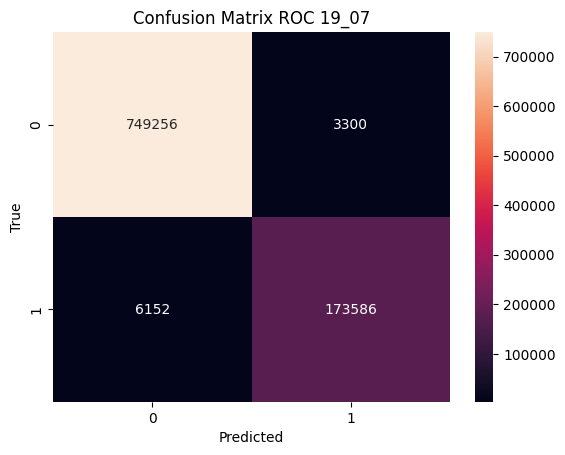

              precision    recall  f1-score   support

       False       0.99      1.00      0.99    752556
        True       0.98      0.97      0.97    179738

    accuracy                           0.99    932294
   macro avg       0.99      0.98      0.98    932294
weighted avg       0.99      0.99      0.99    932294


Accuracy con roc: 0.9898615672738428


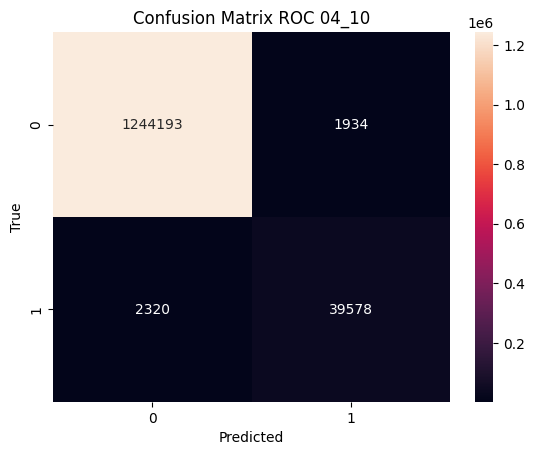

              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1246127
        True       0.95      0.94      0.95     41898

    accuracy                           1.00   1288025
   macro avg       0.98      0.97      0.97   1288025
weighted avg       1.00      1.00      1.00   1288025


Accuracy con roc: 0.9966972690747462


In [ ]:
#19_07 ROC

cm = confusion_matrix(real_labels_19, predicted_labels_roc_19)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix ROC 19_07")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(real_labels_19, predicted_labels_roc_19))
print("\nAccuracy con roc:", accuracy_score(real_labels_19, predicted_labels_roc_19))

#04_10 ROC

cm = confusion_matrix(real_labels_04, predicted_labels_roc_04)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix ROC 04_10")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(real_labels_04, predicted_labels_roc_04))
print("\nAccuracy con roc:", accuracy_score(real_labels_04, predicted_labels_roc_04))

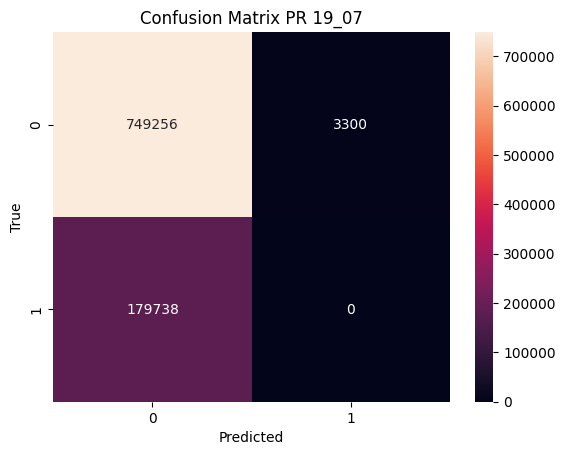

              precision    recall  f1-score   support

       False       0.81      1.00      0.89    752556
        True       0.00      0.00      0.00    179738

    accuracy                           0.80    932294
   macro avg       0.40      0.50      0.45    932294
weighted avg       0.65      0.80      0.72    932294


Accuracy con pr: 0.8036692288055055


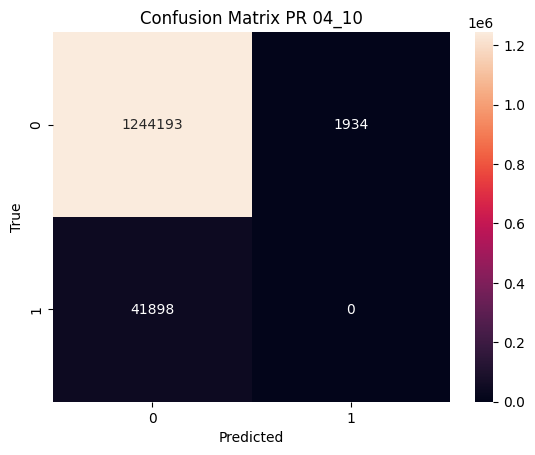

              precision    recall  f1-score   support

       False       0.97      1.00      0.98   1246127
        True       0.00      0.00      0.00     41898

    accuracy                           0.97   1288025
   macro avg       0.48      0.50      0.49   1288025
weighted avg       0.94      0.97      0.95   1288025


Accuracy con pr: 0.9659696046272394


In [ ]:
#19_07 PR

cm = confusion_matrix(real_labels_19, predicted_labels_pr_19)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix PR 19_07")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


print(classification_report(real_labels_19, predicted_labels_pr_19))
print("\nAccuracy con pr:", accuracy_score(real_labels_19, predicted_labels_pr_19))

#04_10 PR

cm = confusion_matrix(real_labels_04, predicted_labels_pr_04)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix PR 04_10")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


print(classification_report(real_labels_04, predicted_labels_pr_04))
print("\nAccuracy con pr:", accuracy_score(real_labels_04, predicted_labels_pr_04))

In [ ]:
#FEATURES 19_07
reconstructions_19 = autoencoder.predict(X_test_19)

feature_names = X_test_19.columns

reconstruction_errors_19 = np.square(reconstructions_19 - X_test_19) # Calcola l'errore di ricostruzione per ciascuna feature

mean_feature_error = np.mean(reconstruction_errors_19, axis=0) # Media dell'errore di ricostruzione su tutti i record per ciascuna feature

feature_error_dict = dict(zip(feature_names, mean_feature_error))

sorted_feature_error = sorted(feature_error_dict.items(), key=lambda x: x[1], reverse=True) # Ordina le feature in base all'errore medio di ricostruzione

plt.figure(figsize=(10, 15))
plt.barh([x[0] for x in sorted_feature_error], [x[1] for x in sorted_feature_error])
plt.gca().invert_yaxis() 
plt.xlabel('Mean Reconstruction Error')
plt.ylabel('Feature Name')
plt.title('Mean Reconstruction Error for Each Feature')
plt.show()

In [ ]:
#FEATURES 04_10
reconstructions_04 = autoencoder.predict(X_test_04)

feature_names = X_test_04.columns

reconstruction_errors_04 = np.abs(reconstructions_04 - X_test_04) # Calcola l'errore di ricostruzione per ciascuna feature

mean_feature_error = np.mean(reconstruction_errors_04, axis=0) # Media dell'errore di ricostruzione su tutti i record per ciascuna feature

feature_error_dict = dict(zip(feature_names, mean_feature_error))

sorted_feature_error = sorted(feature_error_dict.items(), key=lambda x: x[1], reverse=True) # Ordina le feature in base all'errore medio di ricostruzione

plt.figure(figsize=(10, 15))
plt.barh([x[0] for x in sorted_feature_error], [x[1] for x in sorted_feature_error])
plt.gca().invert_yaxis() 
plt.xlabel('Mean Reconstruction Error')
plt.ylabel('Feature Name')
plt.title('Mean Reconstruction Error for Each Feature')
plt.show()